### Clean and Process Methylation Data from JHU

This is part of a workflow that takes a paired-set of files from the Genomic Data Commons along with an annotation file of the Illumina 450k bead chip array. This array generates a comprehensive genome-wide profile of human DNA methylation. 

DNA methylation plays a significant role in the epigenetic regulation of gene expression, development and genetic imprinting in vertebrates. 

In [1]:
import os
import pandas as pd

In [2]:
LONG_RUN = True # set to 'False' to skip long-running processes. 

base           = '../../data/johnshopkins-data/'
pickle_base    = '../../data/pickle/'
directory      = 'LUAD-PAIRED/'
tissue         = 'LUAD'
minor          = 50
major          = 5931         

file_str_norm  = 'TCGA-{minor}-{major}-{tissue}-{status}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                status='Normal', 
                                                                ext='xlsx')
file_str_tumr  = 'TCGA-{minor}-{major}-{tissue}-{status}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                status='Tumor', 
                                                                ext='xlsx')
file_str_picl  = 'TCGA-{minor}-{major}-{tissue}.{ext}'.format(minor=minor,
                                                                major=major,
                                                                tissue=tissue,
                                                                ext='pkl')

anno_str       = 'Illumina-450k-Anno.{rev}.{ext}'.format(rev='hg19',ext='pkl')

tumor          = '{t}_tumor'.format(t=tissue) 
normal         = '{t}_normal'.format(t=tissue)
methylation    = '{t}_methyl'.format(t=tissue)

Read in a pair of files - normal methyl values versus tumor methyl values - from the local filesystem. All data files (i.e. 'TCGA-50-5931-LUSC-Normal') are from https://portal.gdc.cancer.gov/. The Excel format is about 1/3 the size of the raw text files.

In [3]:
if LONG_RUN:
    normal_file   =  pd.read_excel(base + directory + file_str_norm)
    tumor_file    =  pd.read_excel(base + directory + file_str_tumr)
else:
    pass # load object.

Using the above format one may load different datasets and run them below without altering files paths, etc. 

In [4]:
normal_file.head() # raw data contains NaN entries...

,Composite Element REF,Beta_value,Chromosome,Start,End,Gene_Symbol,Gene_Type,Transcript_ID,Position_to_TSS,CGI_Coordinate,Feature_Type
0,cg00000029,0.317716,chr16,53434200,53434201,RBL2;RBL2;RBL2,protein_coding;protein_coding;protein_coding,ENST00000262133.9;ENST00000544405.5;ENST000005...,-221;-1420;222,CGI:chr16:53434489-53435297,N_Shore
1,cg00000108,NaN,chr3,37417715,37417716,C3orf35;C3orf35;C3orf35;C3orf35;C3orf35;C3orf3...,lincRNA;lincRNA;lincRNA;lincRNA;lincRNA;lincRN...,ENST00000328376.8;ENST00000332506.6;ENST000004...,18552;18552;6505;31445;18143;447;18552;18552,CGI:chr3:37451927-37453047,.
2,cg00000109,NaN,chr3,172198247,172198248,FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B;FNDC3B,protein_coding;protein_coding;protein_coding;p...,ENST00000336824.7;ENST00000415807.5;ENST000004...,157692;158618;151333;71272;158587;71273,CGI:chr3:172039703-172040934,.
3,cg00000165,0.251564,chr1,90729117,90729118,.,.,.,.,CGI:chr1:90724932-90727247,S_Shore
4,cg00000236,0.802320,chr8,42405776,42405777,VDAC3,protein_coding,ENST00000022615.7,13872,CGI:chr8:42410918-42411241,.


The files from JHU are 'TCGA Level 3 DNA methylation data' (hg19-based). GDC does liftover to convert the Illumina 450k probes to GRCh38. To understand how GDC does this see: [GDC](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Methylation_LO_Pipeline/). An explanation of the above rows and columns...

| Field                 | Definition                                                                           |
|-----------------------|--------------------------------------------------------------------------------------|
| Composite Element REF | A unique ID for the array probe associated with a CpG site.                          |
| Beta Value            | Ratio between the methylated array intensity and total array intensity.              |
| Chromosome            | The chromosome in which the probe binding site is located.                           |
| Start                 | The start of the CpG site on the chromosome.                                         |
| End                   | The end of the CpG site on the chromosome.                                           |
| Gene Symbol           | Genes associated with the CpG site.                                                  |
| Gene Type             | A classification for each gene (e.g. protein coding, miRNA, pseudogene).             |
| Transcript ID         | Ensembl transcript IDs for each transcript associated with the genes detailed above  |
| Position to TSS       | Distance in base pairs from the CpG site to each associated transcript's start site. |
| CGI Coordinate        | The start and end coordinates of the CpG island associated with the CpG site.        |
| Feature Type          | The position of the CpG site in reference to the island (Island, N_Shore etc.).      |

The next two cells create a pre-edited methyl dataframe that is ultimately merged into a single object and saved to the file system.  

In [5]:
_methyl_df = pd.DataFrame(columns = ['ID_REF', # creates Pandas dataframe w/ columns
                                    tumor, 
                                    normal,])

ID_REF = normal_file['Composite Element REF']

_N_BETA = normal_file['Beta_value'] # column slices from file
_T_BETA =  tumor_file['Beta_value']

In [6]:
_methyl_df['ID_REF'] =  ID_REF  # populate dataframe 
_methyl_df[normal]   = _N_BETA
_methyl_df[tumor]    = _T_BETA

In [7]:
_methyl_df.head()               # NaN's will be removed below...

,ID_REF,LUAD_tumor,LUAD_normal
0,cg00000029,0.277104,0.317716
1,cg00000108,NaN,NaN
2,cg00000109,NaN,NaN
3,cg00000165,0.793160,0.251564
4,cg00000236,0.745634,0.802320


In [8]:
len(_methyl_df)

485577

Initially, the methyl dataframe has 485k rows. We drop those that contain missing values (NaNs) ...

In [9]:
_methyl_df = _methyl_df.dropna(how='any') 
_methyl_df.head()

,ID_REF,LUAD_tumor,LUAD_normal
0,cg00000029,0.277104,0.317716
3,cg00000165,0.793160,0.251564
4,cg00000236,0.745634,0.802320
5,cg00000289,0.566659,0.575215
6,cg00000292,0.333087,0.676057


Dropping NaNs leaves us with a bit less (~390-400k) that the original 485k. The number of NaNs will vary. 

In [10]:
len(_methyl_df)

394028

The code below is sourced from an external file 'annotate_450k.py' containing classes that represent an Illumina 450k probe. This allows us to manipulate probes in arbitrary groups.  

In [11]:
# %load '../methylator/annotation/annotate_450k.py'

import os

class Probe:
    """
    Holds Illumina 450k probe info for a single CpG site.
    """
    def __init__(self):
        self.id = None
        self. seq = None
        self.name = None
        self.chr = None
        self.cord = None
        self.strand = None
        self.gene = None
        self.refseq = None
        self.tour = None
        self.loc = None
        
class Interval:
    """
    Define a genomic interval by chromsome and strand orientation.
    """
    def __init__(self, chromosome, start, end, strand):
        self.chr = chromosome
        self.start = start
        self.end = end
        self.strand = strand

class Location:
    """
    Define a Probe location.
    """
    BODY = "Body"
    TSS200 = "TSS200"
    TSS1500 = "TSS1500"
    UTR5 = "5'UTR"
    UTR3 = "3'UTR"
    EXON = "Exon"

class CpG_location:
    """
    Defines a CpG location.
    """
    ISLAND = "Island"
    NSHORE = "N_Shore"
    SSHORE = "S_Shore"
    NSHELF = "N_Shelf"
    SSHELF = "S_Shelf"
    
class SNP:
    """
    Defines the SNPs in probes. Used to filter probes.
    """

    def __init__(self):
        self.probeid = None
        self.snpid = None
    
class Annotate_450k:
    """
    Parse and hold information about Illumina probes.
    """

    def __init__(self):        
        for i in open(anno_file, mode="r"):
            self.ann = os.path.join("../../data/", i.strip("\n").strip("\r"))

        self.probe = {}
        self.__run__()

    def __run__(self):
        """
        A static function to setup the Probe classes.
        """
        for i in open(self.ann, mode="r"):
            if i.startswith("cg"):
                data = i.split(",")
                # Assign probe information.
                new_probe = Probe()
                new_probe.id = data[0]
                new_probe.name = data[1]
                new_probe.seq = data[13]
                new_probe.chr = str(data[11])
                new_probe.cord = int(data[12])
                new_probe.strand = data[16]
                new_probe.gene = data[21].split(";")
                new_probe.refseq = data[22]
                locs = data[23].split(";")
                list_locs = []
                for i in locs:
                    if i not in list_locs:
                        list_locs.append(i)

                new_probe.loc = list_locs

                new_probe.tour = data[25]
                newcpg = {new_probe.id: new_probe}
                self.probe.update(newcpg)

    def get_probe(self, probe_id): #WORKS
        """
        Return probe info associated with an reference.
        """
        try:
            probe = self.probe[probe_id]
        except Exception as ex:
            probe = None
            print("WARNING: No probe with ref-id of %s found." % probe_id)
        return probe

    def get_all_probes(self):
        """
        Return list of all probes.
        """
        probe_list = []
        for probe in self.probe.keys():
            probe_list.append(self.get_probe(probe))
        return probe_list
    
    def get_probes_by_list(self, list_of_ids):
        """
        Return a list of probes from a list of references.
        """
        out_list = []
        for probe_id in list_of_ids:
            out_list.append(self.get_probe(probe_id))

        return out_list
    
    def get_probe_refs_by_gene(self, gene_name):
        """
        Get all probe references associated with a gene.
        """
        probes = {k: self.probe[k] for k in self.probe if gene_name in self.probe[k].gene}
        return self.get_keys(probes.keys())

    def get_probe_refs_by_location(self, probe_loc):
        """
        Get all probe references associated with a genomic location.
        """
        probes = {k: self.probe[k] for k in self.probe if probe_loc in self.probe[k].loc}
        return self.get_keys(probes.keys())

    def get_keys(self, dic_keys):
        """
        Get Probe reference from probe dictionaries.
        """
        l = []
        for i in dic_keys:
            l.append(i)
        return l

    def get_probes_by_gene(self, gene_name):
        """
        Return list of probes for an associated gene.
        """
        return self.get_probes_by_list(self.get_probe_refs_by_gene(gene_name))

    def get_probes_by_location(self, loc):
        """
        Return list of probes from genomic location.
        """
        return self.get_probes_by_list(self.get_probe_refs_by_location(loc))

    def get_probes_by_cpg(self, cpg_loc):
        """
        Get a list probes from cpg location.
        FIXME
        """
        return self.get_probes_by_list(self.get_probes_by_cpg(cpg_loc))

    def get_probes_by_chr(self, chr_loc):
        """
        Get a list of probes within a certain genomic region
        FIXME
        """
        print (chr_loc.chr)
        probes = {k: self.probe[k] for k in self.probe if
                  self.probe[k].chr == chr_loc.chr}

    def get_probes_by_chr_and_loc(self, chr_loc):
        """
        Get a list of probes within a certain genomic region
        FIXME
        """
        chrom = chr_loc.chr
        start = int(chr_loc.start)
        end = int(chr_loc.end)
        
        #print (chrom, start, stop)

        probes = {k: self.probe[k] for k in self.probe if
                  self.probe[k].chr == chrom and start < self.probe[k].cord < end}
        return probes

    def get_probe_keys_by_chr_and_loc(self, chr_loc):
        """
        Get a list of probe reference *keys* within a genomic region
        FIXME
        """
        probes = self.get_probes_by_chr_and_loc(chr_loc)
        return self.get_keys(probes)

    def get_number(self):
        """
        Return total number of probes.
        """
        number = 0
        for probe_id in self.probe.keys():
            number += 1

        return number

    def get_coord(self, probe):
        """
        Get genomic coordinate of a single probe.
        """
        return probe.cord
    
    def get_sorted_probes_by_id(self):
        """
        Sort probes according to probe id.
        """
        sorted_keys = sorted(list(self.probe.keys()))
        return sorted_keys
    
    def get_sorted_probes_by_chr(self):
        """
        Sort probes according to probe id.
        """
        return sorted(self.get_all_probes(), key=lambda x: x.chr)
    
    def remove_snp_probes(self):
        """
        Removes all SNPs associated with probes.
        """
        snp_list = []
        snp_file = open("../../data/humanmethylation450_dbsnp137.snpupdate.table.v2.sorted.txt", "r")
        for line in snp_file:
            if line.startswith("cg"):
                line = line.strip("\n").strip("\r").split("\t")
                new_snp = SNP()
                new_snp.probeid = line[0]
                new_snp.snpid = line[1]
                snp_list.append(new_snp)

        for snp in snp_list:
            self.probe.pop(snp.probeid)

anno_file = os.path.abspath("../../data/config.ini") # Illumina probe manifest.

# Functions to save/load dictionary objects. 

import _pickle as pickle

def save_obj(obj, name):
    with open('../../data/pickle/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open('../../data/pickle/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

The following creates an annotation object from the Illumina 450k manifest. If the object was created and is local it will load it instead. 

In [12]:
print (pickle_base + anno_str)

../../data/pickle/Illumina-450k-Anno.hg19.pkl


In [13]:
exists_annotate   = os.path.isfile(pickle_base + anno_str)

if LONG_RUN:
    if exists_annotate: # load file
        annotate = load_obj(anno_str[:-4])
    else:
        annotate = Annotate_450k() # create annotation object containing all probes
        save_obj(annotate, anno_str[:-4])


In [14]:
annotate.probe.get('cg00000029') # should return a single probe

At this point we have two big data structures: an annotation object which describes the 450k probes 
(annotate); and a methylation object for each cancer type (i.e. LUAD_methyl_df, GBM_methyl_df, etc.)
We want to merge these into one object but need to clean up the SNPs first.  

In [15]:
# size of annotate before cleaning...
annotate.get_number() 

482421

In [16]:
# after dropping SNPs...
annotate.remove_snp_probes()

Make copies of LUAD_methyl_df and annotate before messing with them:

In [17]:
import copy
COPY = False

if COPY:
    _methyl_df_COPY = _methyl_df.copy(deep=True) # 'deep' i.e. include data and indices.
    annotate_COPY = copy.deepcopy(annotate)

We change the index label to be ID_REF...

In [18]:
_methyl_df = _methyl_df.set_index('ID_REF') # can only run this one time. 
_methyl_df.head()

,LUAD_tumor,LUAD_normal
ID_REF,,
cg00000029,0.277104,0.317716
cg00000165,0.793160,0.251564
cg00000236,0.745634,0.802320
cg00000289,0.566659,0.575215
cg00000292,0.333087,0.676057


In [19]:
# size of LUAD methylation object and annotate object after cleaning...
len(_methyl_df), annotate.get_number()

(394028, 210294)

We want the REF_IDs (from annotate) to correspond to REF_IDs in the methyl_df object. For this we need to find the intersection of REF_IDs in annotate and methyl_df. We accomplish this using Python sets. The following shows an example. 

In [20]:
# find common members among two sets of unique elements
set1 = set([1, 2, 3 ,4 ,5 ,6 ,7 ,8 ,9, 10, 11, 12, 13, 14])
set2 = set([7 ,8 ,9, 10, 11, 12, 13, 14])
dff = set1.intersection(set2)
dff 

{7, 8, 9, 10, 11, 12, 13, 14}

In [21]:
# same as above, applied to the REF_IDs

m_set = set(list(_methyl_df.index))      # unique methyl_df members
a_set = set(list(annotate.probe.keys())) # unique annotate members

m_a_intersect = sorted(m_set.intersection(a_set)) # sort the resulting intersection set

len(m_a_intersect)

183367

In [22]:
# evidence that all REF_IDs are here... 

print(m_a_intersect[0])
print(m_a_intersect[0] in a_set and m_a_intersect[0] in m_set)
print(m_a_intersect[183366])
print(m_a_intersect[183366] in a_set and m_a_intersect[183366] in m_set)

cg00000029
True
cg27666046
True


The difference in size between LUAD_methyl_df and annotate - and the intersection between them - reflects that some probes in the former are removed as SNPs or missing values from the latter. The intersection is what we end up with: a fully-annotated probe set for which we have methylation beta-values. Before merging, a probe (without methylation data) has the following attributes:

In [23]:
cg00035864 = annotate.get_probe('cg00035864')
[a for a in dir(cg00035864) if not a.startswith('__')]

['chr', 'cord', 'gene', 'id', 'loc', 'name', 'refseq', 'seq', 'strand', 'tour']

In [24]:
methyl = _methyl_df.loc[m_a_intersect] # methyl is a df of the final xxxx_methyl set
methyl.head()

,LUAD_tumor,LUAD_normal
ID_REF,,
cg00000029,0.277104,0.317716
cg00000165,0.793160,0.251564
cg00000289,0.566659,0.575215
cg00000363,0.295090,0.268511
cg00000658,0.848555,0.837816


Now all elements in methyl are also contained in annotate...

In [25]:
print('Methyl values for ' + tissue + ' cg00000029: ' + str(list(methyl.loc['cg00000029'])))
print('Methyl values for ' + tissue + ' cg27666046: ' + str(list(methyl.loc['cg27666046'])))
print()
print('Annotation probe found: ' + annotate.probe['cg00000029'].id)
print('Annotation probe found: ' + annotate.probe['cg27666046'].id)

Methyl values for LUAD cg00000029: [0.27710355708451, 0.317716330006585]
Methyl values for LUAD cg27666046: [0.126311568535721, 0.622717662886796]

Annotation probe found: cg00000029
Annotation probe found: cg27666046


There's still a difference in the number of elements in each object. Some found in annotate are not found in methyl.

In [26]:
len(annotate.probe), len(methyl)

(210294, 183367)

Using set operations again (this time, difference) we can find these and remove them...

In [27]:
m_set_two = set(list(methyl.index)) # unique methyl_set members
a_set_two = set(list(annotate.probe.keys())) # unique annotate members
m_a_intersect_two = sorted(a_set_two.difference(m_set_two)) # sort the difference

for item in m_a_intersect_two:
    try:
        annotate.probe.pop(item, None)
    except KeyError:
        pass
    
len(annotate.probe), len(methyl)

(183367, 183367)

Finally, we have two objects cleaned and aligned such that they can be merged. We do this by setting attributes on a new dict object containing only filtered probes from the annotate object along with methyl values for matching probe REF_IDs in the methyl object.   

In [28]:
#LONG_RUN = False 

methyl_probe_dict = {}

if LONG_RUN:
    for index, row in methyl.iterrows(): # annotate and methyl have the same number of rows...
        methyl_probe_dict[index] = annotate.probe.get(index) # so these indexes will match...
        setattr(methyl_probe_dict[index], tumor, row[0]) # and for the matching index, we add the methyl data.
        setattr(methyl_probe_dict[index], normal, row[1])
else:    
    for index, row in methyl.head(5).iterrows():
        methyl_probe_dict[index] = annotate.probe.get(index)
        setattr(methyl_probe_dict[index], tumor, row[0])
        setattr(methyl_probe_dict[index], normal, row[1])
        
len(methyl_probe_dict)

183367

In [29]:
cg00000029 = methyl_probe_dict['cg00000029']
[a for a in dir(cg00000029) if not a.startswith('__')]

['LUAD_normal',
 'LUAD_tumor',
 'chr',
 'cord',
 'gene',
 'id',
 'loc',
 'name',
 'refseq',
 'seq',
 'strand',
 'tour']

Create a boxplot of the methylation values to see how they stack up...

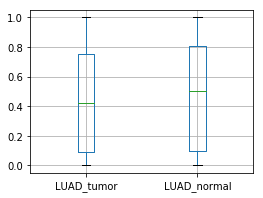

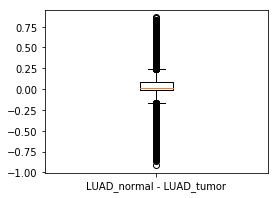

In [98]:
import matplotlib.pyplot as plt 
plt.close('all')

plt.figure(figsize=(4, 3))
_methyl_df.boxplot(column=[tumor, normal])

legend_str = normal + ' - ' + tumor 
# Boxplot of the difference
plt.figure(figsize=(4, 3))
plt.boxplot(_methyl_df[normal] - _methyl_df[tumor])
#plt.xticks((1, ), ('LUAD_normal - LUAD_tumor', ))
plt.xticks((1, ), (legend_str, ))

plt.show() # plot all data from a paired JHU dataset

Finally, we want to save things so we don't have to re-build from scratch. The actual paths where things are saved are: 

In [99]:
print(pickle_base + file_str_picl)
print(pickle_base + anno_str)

../../data/pickle/TCGA-50-5931-LUAD.pkl
../../data/pickle/Illumina-450k-Anno.hg19.pkl


In [100]:
exists_methyl     = os.path.isfile(pickle_base + file_str_picl)
exists_annotate   = os.path.isfile(pickle_base + anno_str)

if exists_methyl:
    pass
else:
    # create file
    save_obj(methyl_probe_dict, file_str_picl[:-4])

if exists_annotate:
    pass
    #annotate = load_obj(anno_str[:-4]) # this is the full annotation, with SNPs, minus our additions. 
else:
    pass

In [101]:
methyl_probe_dict = {}
methyl_probe_dict = load_obj(file_str_picl[:-4]) # let's see if that worked. 

In [102]:
len(methyl_probe_dict), methyl_probe_dict['cg00000029']

(183367, <__main__.Probe at 0x162f42f98>)